# Genetic Algorithms

Genetic algorithms are a type of search algorithm. For more information about Genetic Algorithms please vist the following [link](https://www.mathworks.com/help/gads/what-is-the-genetic-algorithm.html).

In this notebook I will explore the properties and behaviors of genetic algorithms. Specifically, I want to look at how different implementations and hyper parameters effect performance. As an educational exercise, I have created my own library to power these experiments.


In [1]:
import jlearn as jl
from jlearn import *
import time, random, math, multiprocessing
import numpy as np
from functools import partial
import matplotlib.pyplot as plt

Thank you for using jLearn v0.0.1
Contribute to jLearn at https://github.com/lavahoppers/jlearn


## Visualizations

The fitness function I will make can be visualized. If you would like to see it load the modules below. If you are on mac this will not work.

In [2]:
import pygame
import pygame.gfxdraw

ModuleNotFoundError: No module named 'pygame'

## Fitness Function

The fitness function we are using is a small simulation. On an infinite plane, there is one food and one agent. The agent's behavior is controlled by the chromosome. The chromosome is broken into small pieces and used to build a neural network. The network is given the agents position, agent's velocity and the position of the food. The goal of the agent is to eat the food as many times as it can in a certain timeframe. Each time it eats the food, a new food will be spawned in a set area.

We give each agent 1 point for eating a food. In the final position, after the last tick, we will award the agent a partial point based on how close they are to their food. 

To calculate the fitness we do $\text{score}+e^{\text{(-distance)}}$ to avoid problems with negatives. Where the distance is just euclidian.

In [3]:
# number of genes in a chromosome
d = 92

# how long the simulation runs for
ticks=200

# drag coeficient for the agent
C=.1

# for visualizing the simulation
screen_width = 500 # pixels
tick_rate = 20 # ticks per second

def spawn_food():
    "Get the coordinates to a new food somewhere on the screen"
    return np.random.uniform(low=-.8, high=.8, size=(2,1)) * screen_width/2

def fitness(x, visuals=False, samples=1):
    "Calculate the fitness of a chromosome"

    # our fitness function is aproximate... more samples increases acuracy
    if samples > 1:
        return sum([fitness(x, False, 1) for _ in range(samples)])/samples
       
    # init the food
    food = spawn_food()
    
    # init the agent
    score = 0
    W2, W1, b2, b1 = jl.util.multi_reshape(x, [(2,10), (10,6), (2,1), (10,1)])
    pos = np.zeros(shape=(2,1))
    vel = np.zeros(shape=(2,1))

    # init the visuals
    if visuals:
        pygame.init()
        screen = pygame.display.set_mode((screen_width, screen_width))
        font = pygame.font.Font('freesansbold.ttf', 32)
        black = (0, 0, 0)
        red = (255, 0, 0)
        green = (0, 255, 0)
        blue = (0, 0, 255)
        
    # main simulation loop
    for tick in range(ticks):
        
        # get the time that this tick started
        if visuals:
            start_time = time.time()

        # drag the agent (friction)
        vel = vel - C * vel

        # calculate the agent's move
        x1 = np.vstack((pos, vel, food))
        x2 = jl.func.sigmoid(W1@x1+b1)
        x3 = jl.func.sigmoid(W2@x2+b2) * 2 - 1
        acc = x3

        # accelerate and move
        vel += acc
        pos += vel
        
        # calc the distance squared from the food
        diff = pos-food
        sqr_dist = diff.T@diff
        
        # check if the food was eaten
        if sqr_dist < 100:
            score += 1
            food = spawn_food()
            
        if visuals:
            # clear screen 
            screen.fill(black)
            
            # draw the agent
            r = pygame.Rect(pos[0][0]-5+screen_width/2,pos[1][0]-5+screen_width/2,10,10)
            pygame.gfxdraw.rectangle(screen, r, (255, 0, 0))

            # draw the food
            pygame.gfxdraw.circle(screen, int(food[0][0]+screen_width/2), int(food[1][0]+screen_width/2), 3, (255, 255, 0))
            
            # draw the score
            # final score if we stopped at this tick
            dist = math.sqrt(sqr_dist)
            _score = round(score+np.exp(-dist), 2)
            text = font.render(str(_score), False, green, black)
            textRect = text.get_rect()
            screen.blit(text, textRect)

            # update the display
            pygame.display.flip()
            
            # pressing any key kills this function
            for event in pygame.event.get():
                 if event.type in [pygame.QUIT, pygame.KEYDOWN]:
                        pygame.quit()
                        return None
            
            # lock the tick rate (frame rate)
            elapsed = start_time - time.time()
            if elapsed < 1/tick_rate:
                time.sleep(1/tick_rate-elapsed)
    
    # get the final distance to the food
    dist = math.sqrt(sqr_dist)
    # magic number 1000 just to smooth out the curve
    fitness_score = score + np.exp(-dist/1000)
    
    if visuals:            
        pygame.quit()
    
    return fitness_score

## Running the Genetic Algorithm

### Setup (Choosing Hyper-parameters)

We choose how large the population at each step should be. We also choose the type of selection, mutation, and cross-over functions we will use to update the population and the coresponding hyper-parameters.

In [6]:
# population size
n = 100

# sub-routines 
Fitness = partial(fitness, samples=5)
Selection = partial(jl.genetics.select, k=2)
Crossover = jl.genetics.crossover
Mutation = partial(jl.genetics.mutate, rate=0.01)

# elite to maintain from one population to the next
elite = 10

# generations to train for
gens = 50

### Training

Below we loop the jlearn.genetics.step function which will create the new generations. 

In [7]:
# init the population
pop = [np.random.normal(size=(d,)) for _ in range(n)]

# track fitness statistics
mins = [None] * gens
avgs = [None] * gens
maxs = [None] * gens
p5s = [None] * gens
p95s = [None] * gens

for gen in range(gens):

    # get the next generation
    new_pop, scores = jl.genetics.step(pop, Fitness, Selection, Crossover, 
    Mutation, n_elite = elite)
    
    # get the stats for this generation
    p5s[gen] = np.percentile(scores, 5)
    p95s[gen] = np.percentile(scores, 95)
    mins[gen] = min(scores)
    maxs[gen] = max(scores)
    avgs[gen] = sum(scores)/n
            
    # print some statistics
    print(f'gen:{gen:7} Top 5%:{p95s[gen]:7.2f}')
    
    # update the population
    pop = new_pop

gen:      0 Top 5%:   0.79
gen:      1 Top 5%:   0.91
gen:      2 Top 5%:   0.91
gen:      3 Top 5%:   1.01
gen:      4 Top 5%:   1.00
gen:      5 Top 5%:   0.92
gen:      6 Top 5%:   0.88
gen:      7 Top 5%:   0.88
gen:      8 Top 5%:   1.01
gen:      9 Top 5%:   0.95
gen:     10 Top 5%:   1.08
gen:     11 Top 5%:   0.99
gen:     12 Top 5%:   1.05
gen:     13 Top 5%:   1.11
gen:     14 Top 5%:   1.07
gen:     15 Top 5%:   1.23
gen:     16 Top 5%:   1.23
gen:     17 Top 5%:   1.24
gen:     18 Top 5%:   1.31
gen:     19 Top 5%:   1.40
gen:     20 Top 5%:   1.51
gen:     21 Top 5%:   1.48
gen:     22 Top 5%:   1.56
gen:     23 Top 5%:   1.54
gen:     24 Top 5%:   1.65
gen:     25 Top 5%:   1.57
gen:     26 Top 5%:   1.70
gen:     27 Top 5%:   1.50
gen:     28 Top 5%:   1.50
gen:     29 Top 5%:   1.67
gen:     30 Top 5%:   1.53
gen:     31 Top 5%:   1.53
gen:     32 Top 5%:   1.62
gen:     33 Top 5%:   1.52
gen:     34 Top 5%:   1.52
gen:     35 Top 5%:   1.53
gen:     36 Top 5%:   1.52
g

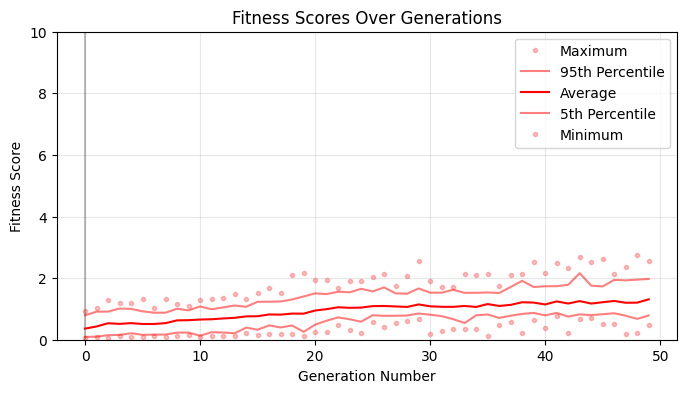

In [8]:
plt.rcParams["figure.figsize"] = (8,4)

plt.grid(alpha=.3)
# plt.axhline(0,c='0', alpha=.25)
plt.axvline(0,c=(0,0,0,.25))

plt.plot(maxs, 'r.', alpha=.25, label='Maximum')
plt.plot(p95s, 'r', alpha=.5, label='95th Percentile')
plt.plot(avgs,  'r', alpha=1, label='Average')
plt.plot(p5s, 'r', alpha=.5, label='5th Percentile')
plt.plot(mins, 'r.', alpha=.25, label='Minimum')

plt.title("Fitness score statistics by generation")
plt.xlabel("Generation number")
plt.ylabel("Fitness score")

plt.legend()
plt.ylim([0, 10])

plt.show()